In [ ]:
from tqdm import tqdm
import json
import os
import torch
from PIL import Image
from torchvision.transforms import ToTensor, Resize, Compose, Normalize
from torch.utils.data import Dataset
from transformers import ViTModel, ViTConfig
import torch.nn as nn
from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.data import DataLoader
import torch.optim as optim
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split

In [ ]:
def plot_keypoints(image, gt_keypoints, pred_keypoints, epoch, idx, phase):
    """
    Plots and saves an image with ground truth and predicted keypoints.

    :param image: The input image as a tensor.
    :param gt_keypoints: Ground truth keypoints.
    :param pred_keypoints: Predicted keypoints.
    :param epoch: Current epoch number.
    :param idx: Index of the batch.
    :param phase: 'train' or 'val' indicating the phase.
    """
    # Convert the image tensor to PIL Image for visualization
    image = image.cpu().squeeze().permute(1, 2, 0)
    image = (image * torch.tensor([0.229, 0.224, 0.225])) + torch.tensor([0.485, 0.456, 0.406])
    image = image.numpy()
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    
    # Plot ground truth keypoints
    gt_keypoints = gt_keypoints.cpu().numpy()
    plt.scatter(gt_keypoints[:, 0], gt_keypoints[:, 1], c='blue', label='Ground Truth', s=10)
    
    # Plot predicted keypoints
    pred_keypoints = pred_keypoints.cpu().numpy()
    plt.scatter(pred_keypoints[:, 0], pred_keypoints[:, 1], c='red', label='Predicted', s=10)

    plt.legend()
    plt.title(f'Epoch {epoch}, Batch {idx}, {phase.capitalize()}')
    
    # Save the figure
    os.makedirs(f'plots/{phase}', exist_ok=True)
    plt.savefig(f'/home/ps332/myViT/plots/{phase}/epoch_{epoch}_batch_{idx}.png')
    plt.close()

In [ ]:
def custom_sigmoid(x):
    return torch.sigmoid(x) * 1.4 - 0.1

In [ ]:
class PoseEstimationDataset(Dataset):
    def __init__(self, json_path, image_dir, transform=None, target_size=(224, 224)):
        self.image_dir = image_dir
        self.transform = transform
        self.target_size = target_size

        with open(json_path, 'r') as file:
            self.data = json.load(file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        max_people = 13
        num_keypoints = 16  # Assuming 16 keypoints per person

        image_path = os.path.join(self.image_dir, item['image_filename'])
        image = Image.open(image_path)
        orig_width, orig_height = image.size

        if self.transform:
            image = self.transform(image)

        keypoints_tensor = torch.zeros((max_people, num_keypoints, 2))
        
        # Normalize the keypoints
        for i, (joint_name, joint_data) in enumerate(item['ground_truth'].items()):
            for j, joint in enumerate(joint_data):
                if j >= max_people:
                    break  # Skip extra people
                x, y = joint[:2]  # Only take x and y, ignoring visibility
                keypoints_tensor[j, i, 0] = x / orig_width
                keypoints_tensor[j, i, 1] = y / orig_height

        # Denormalize the keypoints
        denormalized_keypoints = keypoints_tensor.clone()
        for person in range(max_people):
            for kpt in range(num_keypoints):
                denormalized_keypoints[person, kpt, 0] *= orig_width
                denormalized_keypoints[person, kpt, 1] *= orig_height

         # Create a mask for non-zero keypoints
        valid_keypoints_mask = (keypoints_tensor != 0).any(dim=-1)

        return image, keypoints_tensor, valid_keypoints_mask, denormalized_keypoints, item['image_filename'], orig_width, orig_height    



In [ ]:
num_keypoints = 16  # Assuming 16 keypoints per person
class PoseEstimationModule(nn.Module):
    def __init__(self, num_keypoints, max_people=13):
        super().__init__()
        config = ViTConfig.from_pretrained('google/vit-base-patch16-224')
        self.backbone = ViTModel.from_pretrained('google/vit-base-patch16-224', config=config)
        hidden_size = self.backbone.config.hidden_size

        self.max_people = max_people

        # Head for keypoint coordinates
        self.keypoint_regression_head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size // 2, 2 * num_keypoints * max_people),
            nn.BatchNorm1d(2 * num_keypoints * max_people)
        )

        
    def forward(self, x):
        outputs = self.backbone(x)
        x = outputs.last_hidden_state[:, 0, :]
        x = self.keypoint_regression_head(x)
        x = x.view(x.size(0), self.max_people, num_keypoints, 2)  # Reshape to [batch_size, max_people, num_keypoints, 2]
        x = torch.sigmoid(x)  # Apply sigmoid to constrain values between 0 and 1
        #x = custom_sigmoid(x)  # To constrain values between 0 and 1
        return x

In [ ]:
def calculate_accuracy(predicted_keypoints, gt_keypoints, valid_mask, threshold=0.05):
    """
    Calculate the percentage of keypoints that are correctly predicted within a given threshold,
    considering only the valid keypoints.

    :param predicted_keypoints: Predicted keypoints.
    :param gt_keypoints: Ground truth keypoints.
    :param valid_mask: A boolean mask indicating valid keypoints.
    :param threshold: Distance threshold to consider a prediction as correct.
    :return: Percentage of correctly predicted keypoints.
    """
    # Apply the mask to both predicted and ground truth keypoints
    valid_predicted = predicted_keypoints[valid_mask]
    valid_gt = gt_keypoints[valid_mask]

    # Calculate the L2 distance (Euclidean) between valid predicted and ground truth keypoints
    distances = torch.sqrt(torch.sum((valid_predicted - valid_gt) ** 2, dim=-1))

    # A keypoint is correct if the distance to the ground truth is less than the threshold
    correct = distances < threshold

    # Calculate the percentage of correct keypoints
    accuracy = torch.mean(correct.float()) * 100  # Convert to percentage
    return accuracy.item()

cpu


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/10:   0%|          | 0/382 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[105.7000, 190.4000],
         [106.9250, 144.6667],
         [  0.4891,   0.4708],
         [  0.5219,   0.4111],
         [  0.5000,   0.6347],
         [  0.4906,   0.8611],
         [  0.5055,   0.4417],
         [  0.3852,   0.3403],
         [  0.3816,   0.3366],
         [  0.2949,   0.2453],
         [  0.5148,   0.4264],
         [  0.4938,   0.3639],
         [  0.3711,   0.3611],
         [  0.3984,   0.3181],
         [  0.5016,   0.3444],
         [  0.5211,   0.4194]],

        [[  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000]],

    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[1.4572e+02, 1.3025e+02],
         [1.4723e+02, 1.0329e+02],
         [6.6719e-01, 3.0185e-01],
         [7.3177e-01, 3.0741e-01],
         [6.8906e-01, 4.0463e-01],
         [6.3281e-01, 6.2315e-01],
         [6.9948e-01, 3.0463e-01],
         [6.5781e-01, 1.5556e-01],
         [6.6302e-01, 1.7373e-01],
         [6.2448e-01, 3.9265e-02],
         [5.9948e-01, 3.1204e-01],
         [5.9531e-01, 2.5833e-01],
         [6.1771e-01, 1.3333e-01],
         [6.9740e-01, 1.7685e-01],
         [6.8646e-01, 3.1667e-01],
         [6.4635e-01, 3.1481e-01]],

        [[0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[1.2144e+02, 1.1760e+02],
         [1.1987e+02, 1.0220e+02],
         [5.2108e-01, 3.9167e-01],
         [4.9297e-01, 3.9375e-01],
         [4.8595e-01, 4.5417e-01],
         [4.6956e-01, 5.2292e-01],
         [5.0703e-01, 3.9375e-01],
         [5.0703e-01, 2.9167e-01],
         [5.0878e-01, 2.7161e-01],
         [5.1347e-01, 2.1797e-01],
         [5.4215e-01, 3.8750e-01],
         [5.3864e-01, 3.4792e-01],
         [5.3044e-01, 2.8958e-01],
         [4.8361e-01, 2.9167e-01],
         [4.8009e-01, 3.4792e-01],
         [5.0117e-01, 3.6875e-01]],

        [[1.8492e+02, 1.9320e+02],
         [1.8570e+02, 1.6380e+02],
         [8.4543e-01, 5.8958e-01],
         [7.9625e-01, 5.9583e-01],
         [7.6581e-01, 7.3333e-01],
         [7.7166e-01, 8.7708e-01],
         [8.2084e-01, 5.9375e-01],
         [8.1616e-01, 3.6667e-01],
         [8.1265e-01, 3.2188e-01],
         [8.0328e-01, 2.0742e-01],
         [8.8759e-01, 5.2708e-01],
         [8.8876e-01, 4.5000e-01],
         [8.5480e-

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[5.7225e+01, 1.6084e+02],
         [7.4725e+01, 1.8729e+02],
         [3.1016e-01, 6.0972e-01],
         [3.8594e-01, 5.7639e-01],
         [4.8203e-01, 4.5972e-01],
         [4.3594e-01, 7.6250e-01],
         [3.4844e-01, 5.9306e-01],
         [3.3437e-01, 3.1667e-01],
         [3.3379e-01, 3.1024e-01],
         [3.1465e-01, 8.5634e-02],
         [2.8125e-01, 7.2639e-01],
         [2.3047e-01, 5.4722e-01],
         [2.4922e-01, 3.4444e-01],
         [4.1953e-01, 2.8750e-01],
         [4.9297e-01, 4.0694e-01],
         [4.3437e-01, 5.6806e-01]],

        [[0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[6.5800e+01, 2.2244e+02],
         [7.0875e+01, 1.6333e+02],
         [3.3125e-01, 4.7083e-01],
         [2.8984e-01, 5.1111e-01],
         [2.8359e-01, 7.3889e-01],
         [2.6797e-01, 9.8333e-01],
         [3.1094e-01, 4.9167e-01],
         [3.1406e-01, 2.2639e-01],
         [3.1641e-01, 1.8247e-01],
         [3.2344e-01, 4.5399e-02],
         [4.3672e-01, 1.0139e-01],
         [4.3516e-01, 1.9028e-01],
         [3.4688e-01, 1.8333e-01],
         [2.8047e-01, 2.6806e-01],
         [2.3984e-01, 3.8889e-01],
         [2.8516e-01, 4.8889e-01]],

        [[0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[2.6600e+01, 1.9496e+02],
         [2.6950e+01, 1.5659e+02],
         [1.1771e-01, 4.8611e-01],
         [1.5729e-01, 4.7685e-01],
         [1.6406e-01, 6.7130e-01],
         [1.6146e-01, 8.3056e-01],
         [1.3750e-01, 4.8148e-01],
         [9.4792e-02, 1.7593e-01],
         [1.0254e-01, 1.5116e-01],
         [1.4948e-01, 1.6095e-03],
         [8.2292e-02, 1.7870e-01],
         [2.5521e-02, 3.1944e-01],
         [5.4167e-02, 1.8333e-01],
         [1.3490e-01, 1.6759e-01],
         [1.7292e-01, 2.7500e-01],
         [2.0729e-01, 2.1204e-01]],

        [[0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[7.9100e+01, 2.0326e+02],
         [8.2367e+01, 1.6323e+02],
         [3.7083e-01, 5.1944e-01],
         [3.0937e-01, 5.2407e-01],
         [3.3281e-01, 7.1111e-01],
         [3.3125e-01, 9.2870e-01],
         [3.4010e-01, 5.2222e-01],
         [3.3802e-01, 2.1759e-01],
         [3.5130e-01, 1.6574e-01],
         [3.9089e-01, 1.2008e-02],
         [3.9375e-01, 5.1111e-01],
         [3.9115e-01, 3.7685e-01],
         [3.8958e-01, 2.1296e-01],
         [2.8594e-01, 2.2130e-01],
         [2.8333e-01, 3.8981e-01],
         [3.4167e-01, 5.1389e-01]],

        [[1.1515e+02, 1.9476e+02],
         [1.1772e+02, 1.6344e+02],
         [5.3281e-01, 5.3796e-01],
         [5.7292e-01, 5.4907e-01],
         [5.7812e-01, 7.3611e-01],
         [5.8333e-01, 8.8519e-01],
         [5.5313e-01, 5.4352e-01],
         [5.8281e-01, 3.1204e-01],
         [5.8073e-01, 2.7616e-01],
         [5.7396e-01, 1.5532e-01],
         [5.1406e-01, 1.6574e-01],
         [4.8281e-01, 2.5926e-01],
         [5.4427e-

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[ 84.7000, 143.4222],
         [ 83.3000, 129.1111],
         [  0.3688,   0.5139],
         [  0.3539,   0.5139],
         [  0.3477,   0.5819],
         [  0.3453,   0.6458],
         [  0.3617,   0.5139],
         [  0.3688,   0.4000],
         [  0.3688,   0.3906],
         [  0.3695,   0.3274],
         [  0.3688,   0.4431],
         [  0.3891,   0.4458],
         [  0.3883,   0.4028],
         [  0.3484,   0.3972],
         [  0.3219,   0.4056],
         [  0.2984,   0.4083]],

        [[  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.6008,   0.4861],
         [  0.5875,   0.4889],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.5945,   0.4875],
         [  0.5828,   0.3722],
         [  0.5797,   0.3493],
         [  0.5703,   0.2868],
         [  0.5891,   0.4278],
         [  0.6062,   0.4278],
         [  0.5969,   0.3681],
         [  0.5680,   0.3750],
         [  0.5602,   0.4431],
         [  0.5680,   0.4361]],

    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[118.2951, 152.1688],
         [ 99.4098, 164.9283],
         [  0.5047,   0.5591],
         [  0.5667,   0.5485],
         [  0.6382,   0.8080],
         [  0.6909,   0.7278],
         [  0.5363,   0.5549],
         [  0.4672,   0.3207],
         [  0.4672,   0.3209],
         [  0.3864,   0.1748],
         [  0.5023,   0.5992],
         [  0.4426,   0.4620],
         [  0.4192,   0.3186],
         [  0.5152,   0.3228],
         [  0.6066,   0.4388],
         [  0.5597,   0.5844]],

        [[  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000]],

    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[8.4583e+01, 1.1241e+02],
         [8.3183e+01, 7.3630e+01],
         [3.6875e-01, 2.7500e-01],
         [4.1042e-01, 2.7963e-01],
         [4.2292e-01, 3.8889e-01],
         [4.1510e-01, 5.1944e-01],
         [3.8958e-01, 2.7778e-01],
         [3.9271e-01, 1.2870e-01],
         [3.9141e-01, 1.4028e-01],
         [4.0391e-01, 2.2685e-02],
         [3.6510e-01, 3.0833e-01],
         [3.6042e-01, 2.3056e-01],
         [3.5625e-01, 1.3056e-01],
         [4.2917e-01, 1.2593e-01],
         [4.4688e-01, 2.1019e-01],
         [4.5417e-01, 3.0185e-01]],

        [[0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[160.2222, 182.7259],
         [163.6444, 135.4370],
         [  0.8896,   0.6491],
         [  0.8840,   0.7028],
         [  0.6687,   0.6981],
         [  0.0000,   0.0000],
         [  0.8868,   0.6759],
         [  0.8313,   0.4120],
         [  0.8222,   0.3951],
         [  0.7451,   0.2493],
         [  0.7174,   0.4796],
         [  0.7757,   0.4796],
         [  0.8611,   0.3815],
         [  0.8007,   0.4417],
         [  0.6938,   0.5380],
         [  0.6118,   0.5130]],

        [[  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000]],

    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[ 56.7000, 140.6222],
         [ 68.7750, 126.0000],
         [  0.3430,   0.5069],
         [  0.3820,   0.5153],
         [  0.3398,   0.5764],
         [  0.2945,   0.6431],
         [  0.3625,   0.5111],
         [  0.3609,   0.3486],
         [  0.3600,   0.3208],
         [  0.3564,   0.2167],
         [  0.3195,   0.4431],
         [  0.3234,   0.4181],
         [  0.3234,   0.3514],
         [  0.3984,   0.3444],
         [  0.4195,   0.3847],
         [  0.4109,   0.4250]],

        [[134.2250, 167.3778],
         [140.8750, 149.3333],
         [  0.6508,   0.5764],
         [  0.7141,   0.5986],
         [  0.6883,   0.6778],
         [  0.6695,   0.7736],
         [  0.6828,   0.5875],
         [  0.6875,   0.3917],
         [  0.6922,   0.3785],
         [  0.7344,   0.2634],
         [  0.6070,   0.5722],
         [  0.6180,   0.5028],
         [  0.6430,   0.3847],
         [  0.7320,   0.3972],
         [  0.7383,   0.4694],
         [  0.7383,   0.5333]],

    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[1.4893e+02, 1.5493e+02],
         [1.4788e+02, 1.2133e+02],
         [6.5469e-01, 3.8333e-01],
         [6.8906e-01, 3.9167e-01],
         [6.8672e-01, 5.3889e-01],
         [6.6953e-01, 6.5139e-01],
         [6.7188e-01, 3.8750e-01],
         [6.8672e-01, 2.1528e-01],
         [6.9063e-01, 1.7630e-01],
         [7.0078e-01, 7.9253e-02],
         [6.1719e-01, 4.0000e-01],
         [6.1797e-01, 3.0278e-01],
         [6.4766e-01, 2.0556e-01],
         [7.2500e-01, 2.2361e-01],
         [7.3047e-01, 3.3333e-01],
         [7.3438e-01, 4.2222e-01]],

        [[0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.2672, 0.7597],
         [0.3820, 0.8056],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.3250, 0.7833],
         [0.4211, 0.4861],
         [0.4066, 0.5097],
         [0.5504, 0.2720],
         [0.1977, 0.6097],
         [0.1508, 0.6903],
         [0.3445, 0.4347],
         [0.4969, 0.5361],
         [0.5953, 0.8250],
         [0.5648, 0.7056]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[133.0000, 137.8222],
         [144.5500, 103.6000],
         [  0.7156,   0.2403],
         [  0.7625,   0.2611],
         [  0.7688,   0.5264],
         [  0.7961,   0.7736],
         [  0.7391,   0.2514],
         [  0.6117,   0.1861],
         [  0.6098,   0.1878],
         [  0.5332,   0.2552],
         [  0.5922,   0.5639],
         [  0.6273,   0.4458],
         [  0.5984,   0.1569],
         [  0.6242,   0.2153],
         [  0.6164,   0.4056],
         [  0.5609,   0.5028]],

        [[  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000]],

    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.3562, 0.9271],
         [0.3313, 0.9021],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.3438, 0.9146],
         [0.3297, 0.5854],
         [0.3352, 0.5206],
         [0.3555, 0.2773],
         [0.6062, 0.5292],
         [0.5391, 0.6938],
         [0.3359, 0.5917],
         [0.3234, 0.5792],
         [0.4219, 0.6271],
         [0.5281, 0.5479]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[1.1853e+02, 2.0015e+02],
         [1.1737e+02, 1.6219e+02],
         [5.3333e-01, 5.0278e-01],
         [5.7708e-01, 5.0278e-01],
         [5.9688e-01, 7.1204e-01],
         [5.9844e-01, 8.6574e-01],
         [5.5521e-01, 5.0278e-01],
         [5.5417e-01, 2.7407e-01],
         [5.5469e-01, 2.5486e-01],
         [5.5781e-01, 1.0914e-01],
         [5.0000e-01, 4.3426e-01],
         [4.9740e-01, 3.9167e-01],
         [5.0156e-01, 2.7407e-01],
         [6.0625e-01, 2.7407e-01],
         [6.3281e-01, 3.8981e-01],
         [5.7708e-01, 3.8241e-01]],

        [[0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[3.6633e+01, 1.5327e+02],
         [2.7300e+01, 1.3834e+02],
         [1.7604e-01, 5.3519e-01],
         [1.9948e-01, 5.2407e-01],
         [2.0365e-01, 6.6481e-01],
         [2.1719e-01, 7.9352e-01],
         [1.8802e-01, 5.2963e-01],
         [1.3177e-01, 4.2222e-01],
         [1.3008e-01, 4.1852e-01],
         [9.7005e-02, 3.4444e-01],
         [8.8021e-02, 5.7315e-01],
         [1.0469e-01, 5.0833e-01],
         [1.1198e-01, 4.5093e-01],
         [1.5104e-01, 3.9259e-01],
         [1.5313e-01, 4.8426e-01],
         [1.3073e-01, 5.4630e-01]],

        [[1.0792e+02, 1.6012e+02],
         [9.9283e+01, 1.3979e+02],
         [4.7292e-01, 5.3611e-01],
         [4.9167e-01, 5.2685e-01],
         [4.8906e-01, 6.3704e-01],
         [4.9635e-01, 7.2778e-01],
         [4.8229e-01, 5.3148e-01],
         [4.4740e-01, 4.3519e-01],
         [4.5026e-01, 4.4074e-01],
         [4.2161e-01, 3.8519e-01],
         [4.1719e-01, 5.6667e-01],
         [4.2240e-01, 4.9167e-01],
         [4.2812e-

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[169.4000, 155.7630],
         [172.5500, 124.4445],
         [  0.7135,   0.4778],
         [  0.7047,   0.4602],
         [  0.8052,   0.5157],
         [  0.7964,   0.6472],
         [  0.7094,   0.4694],
         [  0.7615,   0.3454],
         [  0.7682,   0.3289],
         [  0.8057,   0.2359],
         [  0.8302,   0.4935],
         [  0.7901,   0.4444],
         [  0.7651,   0.3546],
         [  0.7578,   0.3352],
         [  0.7766,   0.4463],
         [  0.8203,   0.5046]],

        [[  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000]],

    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Epoch 1/10:   0%|          | 0/382 [00:07<?, ?it/s]


KeyboardInterrupt: 

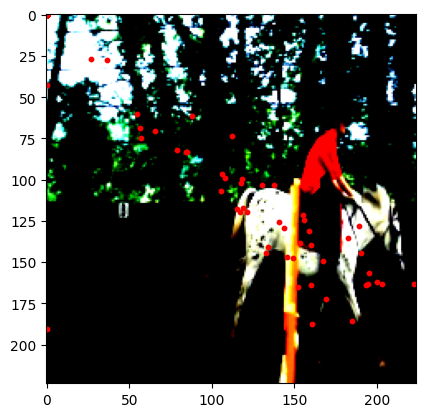

In [9]:
num_epochs = 10
random_seed = 42
torch.manual_seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
   
# Device selection (CUDA GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

json_path = '/home/ps332/myViT/data/mpii_data.json'
image_dir = '/home/ps332/myViT/data/mpii_data/images/images'

# Define any transforms you want to apply to your images
transforms = Compose([
    Resize((224, 224)),  # Resize the image
    ToTensor(),  # Convert the image to a PyTorch tensor
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the tensor
])

# Instantiate the dataset
dataset = PoseEstimationDataset(
    json_path=json_path,
    image_dir=image_dir,
    transform=transforms
)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Initialize the model
model = PoseEstimationModule(num_keypoints=16, max_people=13).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss() # for keypoints regression
#optimizer = optim.Adam(model.parameters(), lr=0.001)
# Use the AdamW optimizer with layer decay
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1, betas=(0.9, 0.999))
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)


def plot_ds(image, keypoints, fname):
    for sample_idx in range(image.shape[0]):
        this_img = image[sample_idx]
        this_kpt = keypoints[sample_idx].detach().cpu()
        this_kpt[:, 0] *= this_img.shape[1]
        this_kpt[:, 1] *= this_img.shape[2]
        plt.imshow(this_img.permute(1, 2, 0).cpu())
        print(this_kpt)
        plt.scatter(this_kpt[:, 0], this_kpt[:, 1], c='red', label='Predicted', s=10)
        plt.savefig(fname + "_sample_" + str(sample_idx) + ".png")


# Training loop
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

# Inside your training loop
    for idx, data in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):

        if idx == 0:
            images, keypoints, valid_mask = data[0].to(device), data[1].to(device), data[2].to(device)
            # Assuming you are storing images in 'plots' directory
            os.makedirs('plots', exist_ok=True)
            plot_ds(images, keypoints, f'plots/epoch_{epoch}_batch_{idx}')


        #print("gt_keypoints" , keypoints)
        
        #denormalized_keypoints = data[2].to(device)  # Denormalized keypoints
        #print("denormalized_keypoints" , denormalized_keypoints)
    
        optimizer.zero_grad()

        predicted_keypoints = model(images)
        #print("predicted_keypoints" , predicted_keypoints)

        # Apply the mask to both predicted and ground truth keypoints
        valid_predicted = predicted_keypoints[valid_mask]
        valid_gt = keypoints[valid_mask]

        #print("valid_predicted" , valid_predicted)
        #print("valid_gt" , valid_gt)

        #accuracy = calculate_accuracy(predicted_keypoints, keypoints, valid_mask)
        #print(f"Batch {idx} - Accuracy: {accuracy}%")

        # Compute loss for keypoints with denormalized ground truth
        #loss_keypoints = criterion(predicted_keypoints, denormalized_keypoints)
    
        # compute loss for normalized keypoints
        loss = criterion(valid_predicted, valid_gt)
        loss.backward()
        optimizer.step()

        lr_scheduler.step()
        running_train_loss += loss.item()

        # Plot and save the training images with keypoints
        #if idx % 10 == 0:  # Adjust the frequency as needed
        #    plot_keypoints(images[0], keypoints[0], predicted_keypoints[0], epoch, idx, 'train')

    
    # Calculate and print the average training loss after all batches
    avg_train_loss = running_train_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Training Loss: {avg_train_loss:.4f}")
    

# Validation step
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for data in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, keypoints = data[:2]
            images, keypoints = images.to(device), keypoints.to(device)
            #print("gt_keypoints" , keypoints)


            predicted_keypoints = model(images)
            #accuracy = calculate_accuracy(predicted_keypoints, keypoints)
            #print(f"Batch {idx} - Accuracy: {accuracy}%")

            #print("predicted_keypoints" , predicted_keypoints)

            loss = criterion(predicted_keypoints, keypoints)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}] - Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

       # Update the learning rate
    lr_scheduler.step()